In [47]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


## Load the Data
#### First we load the datasets into dataframes. 

In [48]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
df_submission = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...
413,1305,3,"Spector, Mr. Woolf",male,NaN,0,0,A.5. 3236,8.0500,NaN,S
414,1306,1,"Oliva y Ocana, Dona. Fermina",female,39.0,0,0,PC 17758,108.9000,C105,C
415,1307,3,"Saether, Mr. Simon Sivertsen",male,38.5,0,0,SOTON/O.Q. 3101262,7.2500,NaN,S
416,1308,3,"Ware, Mr. Frederick",male,NaN,0,0,359309,8.0500,NaN,S


In [49]:
df_submission
# we want to predict the whether a passenget survives (1 or 0)

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0


## Approach
- Since the outcome is binary - predicting whether a passenger survived or not - we use a Binary Classification ML algorithm 
- 2 Binary Classification algorithms will be tried: Random Forest and XGBoost
- Random Forest and XGBoost already have embedded feature selection algorithms
- For exploratory analysis, we will perform feature correlation
- Since we only have a few features, we can do feature selection by implementing feature importance. Then we retrain on lesser number of features and observe if the accuracy improves.
- To assess the performance of the models, we use Accuracy as the main metric. We will also compute for other metrics such as precision, recall, AUC, and F1.

#### A. Data Processing
- Remove unnecessary columns such as Name, Passenger ID, and Ticket
- Apply Imputation for columns with missing values 
- Apply Standardization/Normalization of features with continuous variables

We retain the following features in the dataset: "Pclass","Sex","Age","SibSp","Parch","Fare","Cabin","Embarked"

In [50]:
df_training_filtered = df_train[["Pclass","Sex","Age","SibSp","Parch","Fare","Cabin","Embarked","Survived"]]
df_test_filtered = df_test[["Pclass","Sex","Age","SibSp","Parch","Fare","Cabin","Embarked"]]

df_training_filtered['Cabin'] = df_training_filtered['Cabin'].str.replace("\d", " ")
df_test_filtered['Cabin'] = df_test_filtered['Cabin'].str.replace("\d", " ")
df_training_filtered

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: The default value of regex will change from True to False in a future version.
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: FutureWarning: The default value of regex will change from True to False in a future version.
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentat

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,NaN,S,0
1,1,female,38.0,1,0,71.2833,C,C,1
2,3,female,26.0,0,0,7.9250,NaN,S,1
3,1,female,35.0,1,0,53.1000,C,S,1
4,3,male,35.0,0,0,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,NaN,S,0
887,1,female,19.0,0,0,30.0000,B,S,1
888,3,female,NaN,1,2,23.4500,NaN,S,0
889,1,male,26.0,0,0,30.0000,C,C,1


In [51]:
set(df_training_filtered['Cabin'].to_list())

{'A ',
 'A  ',
 'B ',
 'B  ',
 'B   ',
 'B   B  ',
 'B   B   B  ',
 'B   B   B   B  ',
 'C ',
 'C  ',
 'C   ',
 'C   C  ',
 'C   C   C  ',
 'D',
 'D ',
 'D  ',
 'D   D  ',
 'E ',
 'E  ',
 'E   ',
 'F ',
 'F  ',
 'F E  ',
 'F G  ',
 'G ',
 'T',
 nan}

We can see here that some rows in the Cabin column has multiple inputs. Let's just take the highest class (letter) from cells with multiple classes. We write a function to do this.

In [52]:
#  this function gets highest cabin class of a passenger
def cabin_class(df):
    cab = []
    for i in df:
        if type(i) != float:
            cabins_alpha = list(set(i.split()))
            if len(cabins_alpha) > 1:
                cab.append(cabins_alpha[1]) # only highest class is saved as the class
            else:
                cab.append(cabins_alpha[0])
        else:
            cab.append(i)
    
    return cab

Now there's only single letter classes remaining in both the training and test datasets.

In [53]:
df_training_filtered['Cabin'] = cabin_class(df_training_filtered['Cabin'])
df_test_filtered['Cabin'] = cabin_class(df_test_filtered['Cabin'])
set(df_training_filtered['Cabin'].to_list()) # all unique cabin classes

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


{'A', 'B', 'C', 'D', 'E', 'F', 'G', 'T', nan}

In [54]:
df_training_filtered

,Pclass,Sex,Age,SibSp,Parch,Fare,Cabin,Embarked,Survived
0,3,male,22.0,1,0,7.2500,NaN,S,0
1,1,female,38.0,1,0,71.2833,C,C,1
2,3,female,26.0,0,0,7.9250,NaN,S,1
3,1,female,35.0,1,0,53.1000,C,S,1
4,3,male,35.0,0,0,8.0500,NaN,S,0
...,...,...,...,...,...,...,...,...,...
886,2,male,27.0,0,0,13.0000,NaN,S,0
887,1,female,19.0,0,0,30.0000,B,S,1
888,3,female,NaN,1,2,23.4500,NaN,S,0
889,1,male,26.0,0,0,30.0000,C,C,1


Next, we check if there are any NaN values in our datasets.

In [55]:
# check if there are missing values in the features of training dataset
for dataset, name in zip([df_training_filtered, df_test_filtered], ['Training dataset ', 'Test dataset ']):
    print(name)
    print("Pclass:", dataset['Pclass'].hasnans) # false
    print('Sex:', dataset['Sex'].hasnans) # false
    print('Age:', dataset['Age'].hasnans) # true
    print('SibSp:', dataset['SibSp'].hasnans) # false
    print('Fare:', dataset['Fare'].hasnans) #false
    print('Cabin:', dataset['Cabin'].hasnans) # true -- > can be converted to No Cabin
    print('Embarked:', dataset['Embarked'].hasnans) # true --> can be Unknown
    print()

Training dataset 
Pclass: False
Sex: False
Age: True
SibSp: False
Fare: False
Cabin: True
Embarked: True

Test dataset 
Pclass: False
Sex: False
Age: True
SibSp: False
Fare: True
Cabin: True
Embarked: False



True means there are NaN values. We can apply Imputation using the Mean Method to fill these NaN cells for continuous variables. We don't want to just drop entire rows of datapoints if they have a NaN. Let's create a function to do that.

In [56]:
# Apply imputation to using Mean method
def mis_impute(data):
    imputed = []
    for i in data:
        if i != i:
            imputed.append(data.mean())
        else:
            imputed.append(i)
    return imputed

In [57]:
# Age and Fare have missing values so let's apply imputation on those columns.
df_training_filtered['Age'] = mis_impute(df_training_filtered['Age'])

df_test_filtered['Age'] = mis_impute(df_test_filtered['Age'])
df_test_filtered['Fare'] = mis_impute(df_test_filtered['Fare'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: ht

While Cabin and Embarked have missing values, these will be eliminated once we apply one-encoding of the categorical variables. We use one-hot encoding on the categorical variables so the model will not detect any ordered relationship between classes

In [58]:
# Apply one-hot encoding to Sex, Embarked, and Cabin

one_hot_encoded_data = pd.get_dummies(df_training_filtered, columns = ['Embarked','Sex','Pclass','Cabin'])
one_hot_encoded_data_test = pd.get_dummies(df_test_filtered, columns = ['Embarked','Sex','Pclass','Cabin'])
print(one_hot_encoded_data_test.columns) # remove "Survived" later

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G'],
      dtype='object')


The Cabin column in the test dataset does not have a T class; no datapoint has a T as a Cabin class. But we will include a column for Cabin_T anyway because the model will be trained on the training dataset with Cabine_T column.

In [59]:
# add Cabin_T to feature for test dataset
cabin_t = []
for t in range(len(one_hot_encoded_data_test)):
    cabin_t.append(0)
one_hot_encoded_data_test['Cabin_T'] = cabin_t

In [60]:
print(one_hot_encoded_data_test.columns)
print(one_hot_encoded_data.columns)

# training and test dataframes now have same number of features

Index(['Age', 'SibSp', 'Parch', 'Fare', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T'],
      dtype='object')
Index(['Age', 'SibSp', 'Parch', 'Fare', 'Survived', 'Embarked_C', 'Embarked_Q',
       'Embarked_S', 'Sex_female', 'Sex_male', 'Pclass_1', 'Pclass_2',
       'Pclass_3', 'Cabin_A', 'Cabin_B', 'Cabin_C', 'Cabin_D', 'Cabin_E',
       'Cabin_F', 'Cabin_G', 'Cabin_T'],
      dtype='object')


In [61]:
one_hot_encoded_data_test

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,34.50000,0,0,7.8292,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,47.00000,1,0,7.0000,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
2,62.00000,0,0,9.6875,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,27.00000,0,0,8.6625,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
4,22.00000,1,1,12.2875,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,30.27259,0,0,8.0500,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
414,39.00000,0,0,108.9000,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
415,38.50000,0,0,7.2500,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
416,30.27259,0,0,8.0500,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0


Now let's apply normalization on the continuous variables. We do this so the model does not give more importance to columns with larger numbers. We use Min-Max method to normalize the numbers on a scale of 0-1.

In [62]:
# Apply Min-Max to Age, Fare, SibSp, and Parch
one_hot_encoded_data['Age']=(one_hot_encoded_data['Age']-one_hot_encoded_data['Age'].min())/(one_hot_encoded_data['Age'].max()-one_hot_encoded_data['Age'].min())
one_hot_encoded_data['Fare']=(one_hot_encoded_data['Fare']-one_hot_encoded_data['Fare'].min())/(one_hot_encoded_data['Fare'].max()-one_hot_encoded_data['Fare'].min())
one_hot_encoded_data['SibSp']=(one_hot_encoded_data['SibSp']-one_hot_encoded_data['SibSp'].min())/(one_hot_encoded_data['SibSp'].max()-one_hot_encoded_data['SibSp'].min())
one_hot_encoded_data['Parch']=(one_hot_encoded_data['Parch']-one_hot_encoded_data['Parch'].min())/(one_hot_encoded_data['Parch'].max()-one_hot_encoded_data['Fare'].min())


one_hot_encoded_data_test['Age']=(one_hot_encoded_data_test['Age']-one_hot_encoded_data_test['Age'].min())/(one_hot_encoded_data_test['Age'].max()-one_hot_encoded_data_test['Age'].min())
one_hot_encoded_data_test['Fare']=(one_hot_encoded_data_test['Fare']-one_hot_encoded_data_test['Fare'].min())/(one_hot_encoded_data_test['Fare'].max()-one_hot_encoded_data_test['Fare'].min())
one_hot_encoded_data_test['SibSp']=(one_hot_encoded_data_test['SibSp']-one_hot_encoded_data_test['SibSp'].min())/(one_hot_encoded_data_test['SibSp'].max()-one_hot_encoded_data_test['SibSp'].min())
one_hot_encoded_data_test['Parch']=(one_hot_encoded_data_test['Parch']-one_hot_encoded_data_test['Parch'].min())/(one_hot_encoded_data_test['Parch'].max()-one_hot_encoded_data_test['Fare'].min())


The final training dataframe is now good for training.

In [63]:
one_hot_encoded_data

,Age,SibSp,Parch,Fare,Survived,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,...,Pclass_2,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0.271174,0.125,0.000000,0.014151,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
1,0.472229,0.125,0.000000,0.139136,1,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0
2,0.321438,0.000,0.000000,0.015469,1,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
3,0.434531,0.125,0.000000,0.103644,1,0,0,1,1,0,...,0,0,0,0,1,0,0,0,0,0
4,0.434531,0.000,0.000000,0.015713,0,0,0,1,0,1,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.000,0.000000,0.025374,0,0,0,1,0,1,...,1,0,0,0,0,0,0,0,0,0
887,0.233476,0.000,0.000000,0.058556,1,0,0,1,1,0,...,0,0,0,1,0,0,0,0,0,0
888,0.367921,0.125,0.333333,0.045771,0,0,0,1,1,0,...,0,1,0,0,0,0,0,0,0,0
889,0.321438,0.000,0.000000,0.058556,1,1,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0


#### C. Exploratory Analysis
- We take a look at the relationships of the features with each other and with the outcome variable Survived. Through this we will be able to observe feature interactions and possibly delete redundant features.
- Apply Spearman correlation between continuous variables
- Apply Point Bisceral Correlation to determine pairwise correlation between Survived and the Continuous Variables
- Apply Point Bisceral Correlation to determine pairwise correlation between the Continuous Variables
- Apply Chi-squared test to determine correlation between Survived and Categorical variables

In [64]:
# Spearman correlation between two continuous variables - Age and Fare
from scipy.stats import spearmanr

continuous_features = one_hot_encoded_data[['Age','SibSp','Parch','Fare']]

# apply correlation matrix on continuous variables
corr = continuous_features.corr(method='spearman')
corr.style.background_gradient(cmap='coolwarm')

,Age,SibSp,Parch,Fare
Age,1.000000,-0.147035,-0.217290,0.118847
SibSp,-0.147035,1.000000,0.450014,0.447113
Parch,-0.217290,0.450014,1.000000,0.410074
Fare,0.118847,0.447113,0.410074,1.000000


## 1. Spearman Correlation

Applying Spearman correlation between the continuous variables, we see that Parch and SibSp are positively correlated, as well as Fare and SibSp, and Fare and Parch. This makes sense as Parch refers to the number of parents and children, while SibSp refers to the number of siblings. The higher the number of people for a passenger, the higher their fare would be.

There is also a slight positive correlation between Age and Fare. This means that the older the passenger is, the higher their fare.

In [65]:
# Apply Point Bisceral Correlation between Survived (binary variable) and Continuous Variables
from scipy import stats

for i in ['Age','SibSp','Parch','Fare']:
    print(i, stats.pointbiserialr(one_hot_encoded_data['Survived'], continuous_features[i]))

Age PointbiserialrResult(correlation=-0.06980851528714307, pvalue=0.037217083726811706)
SibSp PointbiserialrResult(correlation=-0.03532249888573552, pvalue=0.29224392869800375)
Parch PointbiserialrResult(correlation=0.08162940708348347, pvalue=0.014799245374712841)
Fare PointbiserialrResult(correlation=0.2573065223849624, pvalue=6.120189341917992e-15)


Applying Point Bisceral correlation, we can see that there is a statistically significant correlation between survival and age, number of parents, and fare. Fare has a the largest positive correlation to Survived. This possibly implies that people belonging to a higher economic class survived more.

Let's visualize the distribution of the variables in the two groups in Survived (0 or 1).

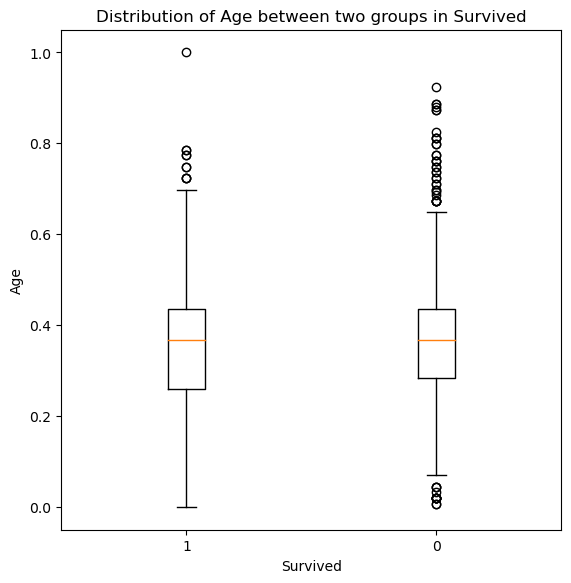

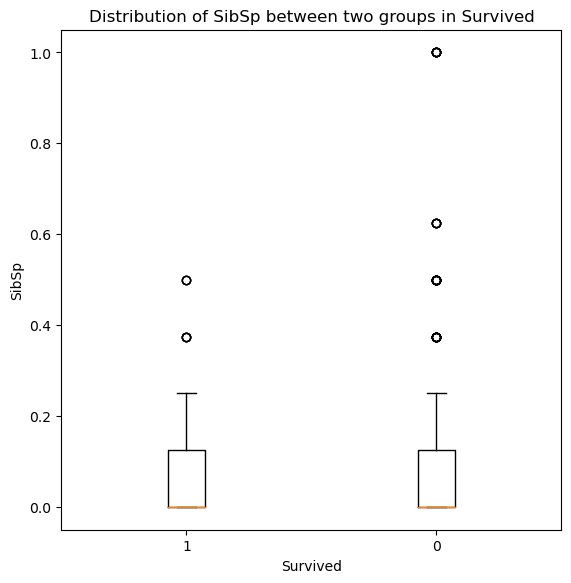

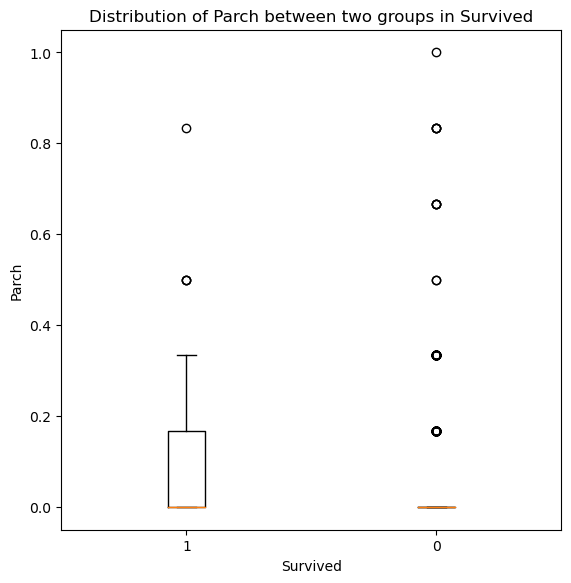

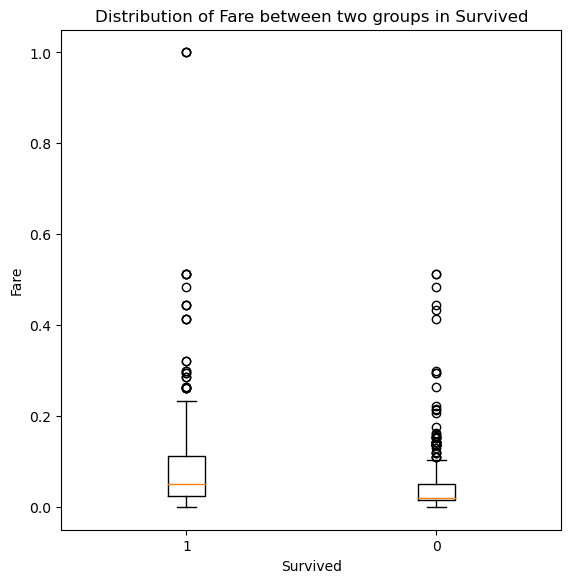

In [66]:
# plot of distribution of Survived (1 or 0) against continuous variable
for i in ['Age','SibSp','Parch','Fare']:
    data = [one_hot_encoded_data[one_hot_encoded_data['Survived'] == 1][i], \
           one_hot_encoded_data[one_hot_encoded_data['Survived'] == 0][i]]

    fig = plt.figure(figsize =(5,5))
    ax = fig.add_axes([0, 0, 1, 1])
    bp = ax.boxplot(data)
    ax.set_xticklabels(['1','0'])
    plt.xlabel('Survived')
    plt.ylabel(i)
    plt.title('Distribution of ' + i +' between two groups in Survived')
    plt.show()

## 2. Chi-Square Test
Apply pairwise correlation between between the Binary Variables (Chi-Square Test)

To start applying correlation to categorical variables, let's drop continuous variables from the dataset.

In [67]:
binary_variables = one_hot_encoded_data.drop(['Age','SibSp','Parch','Fare'], axis=1)
binary_variables

,Survived,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
1,1,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
2,1,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
3,1,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0
4,0,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0
887,1,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0
888,0,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
889,1,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0


In [68]:
from scipy.stats import chi2_contingency

corr_chi2 = np.zeros((17, 17))

# store variables with significant correlation with Survived
variables_correlated_w_survived = []
correlated_w_survived_contingency_tables = []
for i, a in enumerate(binary_variables.columns):
    for j, b in enumerate(binary_variables.columns):
        CrosstabResult=pd.crosstab(index=binary_variables[a], columns=binary_variables[b])
        ChiSqResult = chi2_contingency(CrosstabResult)
        corr_chi2[i,j] = ChiSqResult[1]
        if a == 'Survived':
            if ChiSqResult[1] < 0.05:
                variables_correlated_w_survived.append([b, ChiSqResult[1]])
                correlated_w_survived_contingency_tables.append(CrosstabResult)

Let's take a look at variables with statistically significant correlation with Survived, i.e. p-value is less than 0.05.

In [69]:
variables_correlated_w_survived

[['Survived', 7.352052198553542e-195],
 ['Embarked_C', 8.062166851376562e-07],
 ['Embarked_S', 4.889994039683623e-06],
 ['Sex_female', 1.1973570627755645e-58],
 ['Sex_male', 1.1973570627755645e-58],
 ['Pclass_1', 2.821002116713357e-17],
 ['Pclass_2', 0.006906243870048795],
 ['Pclass_3', 1.277904920294387e-21],
 ['Cabin_B', 3.927607300066705e-07],
 ['Cabin_C', 0.0010241520530316962],
 ['Cabin_D', 1.58579266498021e-05],
 ['Cabin_E', 1.58579266498021e-05],
 ['Cabin_F', 0.03590155166921058]]

From this result, we can see that gender, class, cabin, and embarked (place of origin of the passenger) are correlated with survival.

Let's take a look at the contingency table to see the distrubution of the binary classes to Survived (0 or 1)

In [70]:
correlated_w_survived_contingency_tables

[Survived    0    1
 Survived          
 0         549    0
 1           0  342,
 Embarked_C    0   1
 Survived           
 0           474  75
 1           249  93,
 Embarked_S    0    1
 Survived            
 0           122  427
 1           125  217,
 Sex_female    0    1
 Survived            
 0           468   81
 1           109  233,
 Sex_male    0    1
 Survived          
 0          81  468
 1         233  109,
 Pclass_1    0    1
 Survived          
 0         469   80
 1         206  136,
 Pclass_2    0   1
 Survived         
 0         452  97
 1         255  87,
 Pclass_3    0    1
 Survived          
 0         177  372
 1         223  119,
 Cabin_B     0   1
 Survived         
 0         537  12
 1         307  35,
 Cabin_C     0   1
 Survived         
 0         525  24
 1         307  35,
 Cabin_D     0   1
 Survived         
 0         541   8
 1         317  25,
 Cabin_E     0   1
 Survived         
 0         541   8
 1         317  25,
 Cabin_F     0  1
 Survived 

Then by plotting a heatmap, we can also see the pairwise correlation between all the categorical variables and see feature interactions between them.

The darker-colored tiles have p-value approaching 0, which means the correlation is statistically significant.

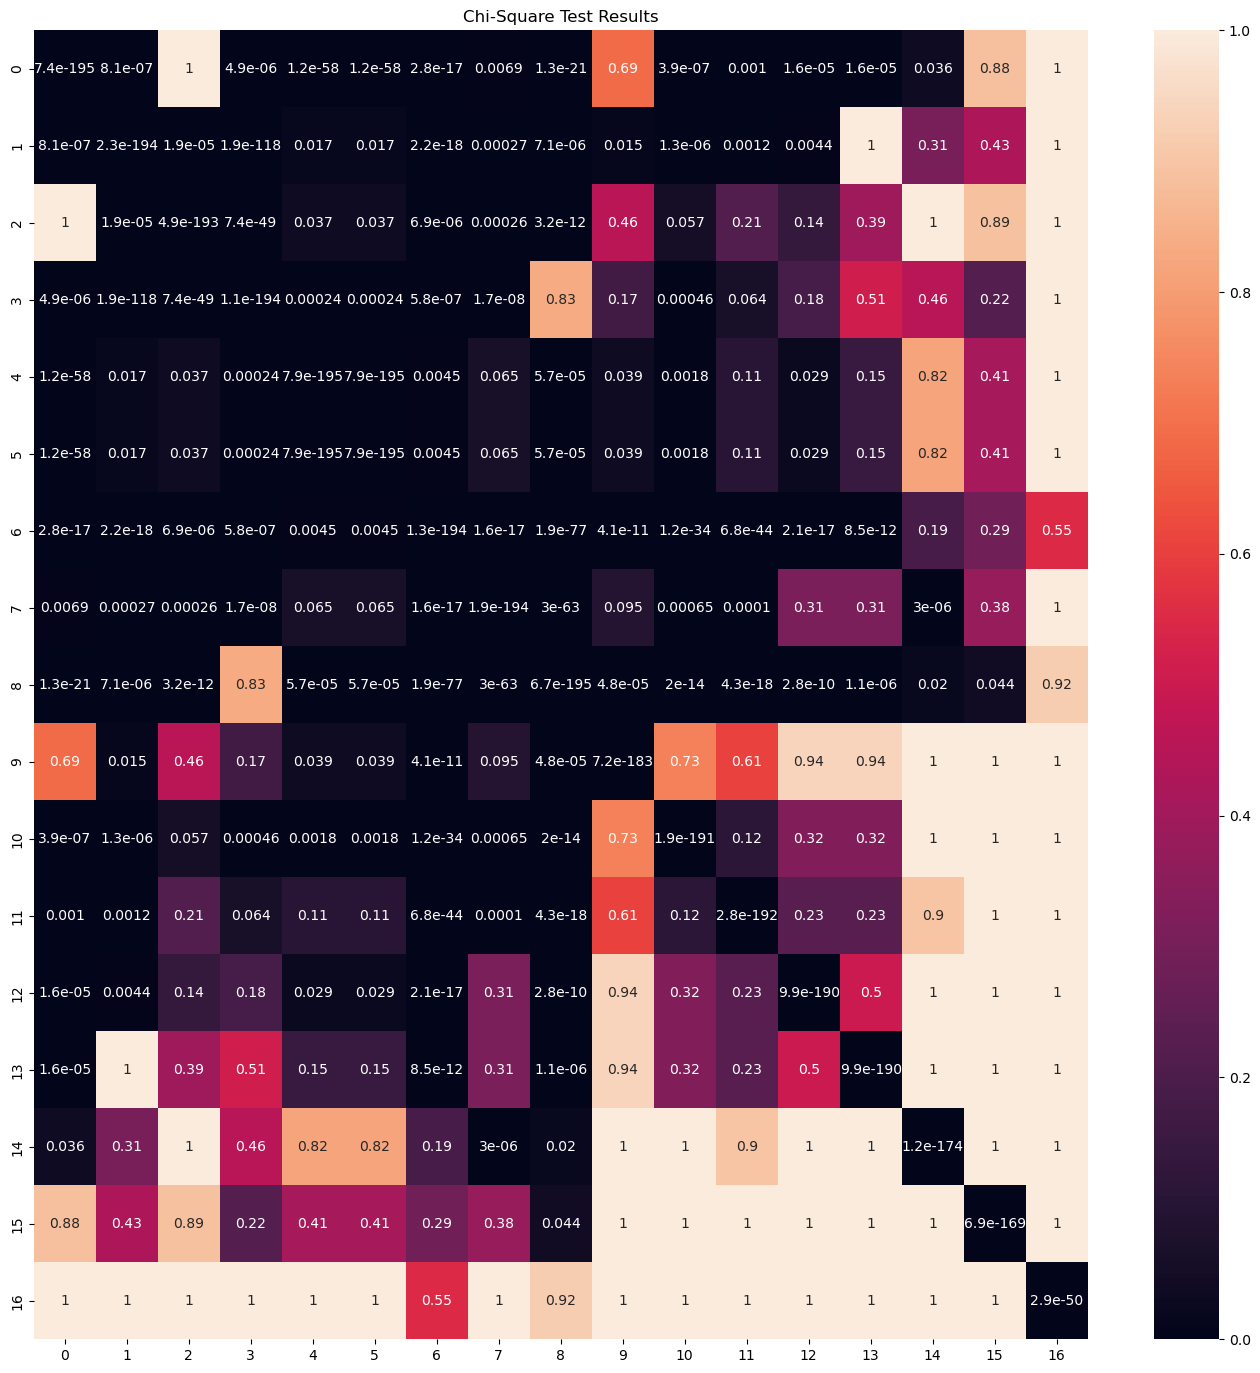

In [71]:
import seaborn as sns
fig = plt.figure(figsize=(17,17))
sns.heatmap(corr_chi2, annot=True)
sns.diverging_palette(145, 300, s=60, as_cmap=True)
plt.title('Chi-Square Test Results')
plt.show()

# p-value less than 0.05 means the variables are correlated

#### D. Model Training
- Hyperparameter tuning with 10-fold cross validation on training dataset
- Fit best parameters on model 
- Random Forest and XGBoost are algorithms with robust feature selection 

Since we only have a few features in the first place, it is easier if we train the model on all the features on first iteration then apply feature importance. Once we get the feature importance for each model, we train the model on lesser number of features and observe if the accuracy improves, stays the same, or worsens.

Let's start by extracting the features and the outcome variables and putting them in separate dataframes.

In [72]:
X_train = one_hot_encoded_data.drop(["Survived"], axis=1)
y_train = one_hot_encoded_data['Survived']

X_test = one_hot_encoded_data_test

In [73]:
X_test

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0.452723,0.000,0.000000,0.015282,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0
1,0.617566,0.125,0.000000,0.013663,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
2,0.815377,0.000,0.000000,0.018909,0,1,0,0,1,0,1,0,0,0,0,0,0,0,0,0
3,0.353818,0.000,0.000000,0.016908,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
4,0.287881,0.125,0.111111,0.023984,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
413,0.396975,0.000,0.000000,0.015713,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
414,0.512066,0.000,0.000000,0.212559,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
415,0.505473,0.000,0.000000,0.014151,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
416,0.396975,0.000,0.000000,0.015713,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0


In [74]:
X_train

,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S,Sex_female,Sex_male,Pclass_1,Pclass_2,Pclass_3,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,Cabin_F,Cabin_G,Cabin_T
0,0.271174,0.125,0.000000,0.014151,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
1,0.472229,0.125,0.000000,0.139136,1,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
2,0.321438,0.000,0.000000,0.015469,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
3,0.434531,0.125,0.000000,0.103644,0,0,1,1,0,1,0,0,0,0,1,0,0,0,0,0
4,0.434531,0.000,0.000000,0.015713,0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0.334004,0.000,0.000000,0.025374,0,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0
887,0.233476,0.000,0.000000,0.058556,0,0,1,1,0,1,0,0,0,1,0,0,0,0,0,0
888,0.367921,0.125,0.333333,0.045771,0,0,1,1,0,0,0,1,0,0,0,0,0,0,0,0
889,0.321438,0.000,0.000000,0.058556,1,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0


## Random Forest

As part of the modelling, we perform hyperparameter tuning with cross-validation. We create a function that performs hyperparameter tuning on a range of parameters specific to our Random Forest model. At the same time, we include 10-fold cross validation which should make the model more generalizable.

In [75]:
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, make_scorer, accuracy_score, auc
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_curve

def hyperparameter_tuning_RFC2(X_train, y_train):
    # Performs hyperparameter tuning of the Random Forest model

    model_dtc = RandomForestClassifier()

    # range of parameters for training
    param_grid = {
        'n_estimators': range(1, 25),
        'max_features': [0.1, 0.2, 0.3, 0.4],
        'max_samples': [0.5, 0.6, 0.7, 0.8],
        'criterion': ['gini'],
        'random_state': [42],
    }
    
    # grid search with 10-fold cross validation
    CV_rfc = GridSearchCV(estimator=model_dtc, param_grid=param_grid, cv= 10, n_jobs=-1, \
                          scoring=['recall','precision','f1','roc_auc','accuracy'], refit='accuracy')
    CV_rfc.fit(X_train, y_train)


    # records scores of each parameter combinations and stores in a pandas dataframe
    df_hyperparameters = pd.DataFrame(data={"Parameters": CV_rfc.cv_results_['params'], \
                                            "mean_test_recall": CV_rfc.cv_results_['mean_test_recall'], \
                                            "mean_test_precision": CV_rfc.cv_results_['mean_test_precision'], \
                                            "mean_test_f1": CV_rfc.cv_results_['mean_test_f1'],\
                                            "mean_test_roc_auc": CV_rfc.cv_results_['mean_test_roc_auc'], \
                                            "mean_test_accuracy": CV_rfc.cv_results_['mean_test_accuracy']})
    
    return df_hyperparameters

In [76]:
df_RFC = hyperparameter_tuning_RFC2(X_train, y_train)

In [77]:
df_RFC

,Parameters,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,mean_test_accuracy
0,"{'criterion': 'gini', 'max_features': 0.1, 'ma...",0.632185,0.630836,0.627708,0.697575,0.718390
1,"{'criterion': 'gini', 'max_features': 0.1, 'ma...",0.541597,0.764126,0.629728,0.777494,0.759913
2,"{'criterion': 'gini', 'max_features': 0.1, 'ma...",0.702353,0.717537,0.705803,0.804255,0.777878
3,"{'criterion': 'gini', 'max_features': 0.1, 'ma...",0.637899,0.758942,0.688758,0.810970,0.783471
4,"{'criterion': 'gini', 'max_features': 0.1, 'ma...",0.713697,0.734331,0.721358,0.823845,0.790137
...,...,...,...,...,...,...
379,"{'criterion': 'gini', 'max_features': 0.4, 'ma...",0.707647,0.786208,0.741505,0.855447,0.813783
380,"{'criterion': 'gini', 'max_features': 0.4, 'ma...",0.716387,0.776654,0.742176,0.855607,0.811548
381,"{'criterion': 'gini', 'max_features': 0.4, 'ma...",0.707563,0.784515,0.740653,0.855663,0.813758
382,"{'criterion': 'gini', 'max_features': 0.4, 'ma...",0.710504,0.774269,0.737632,0.857094,0.809301


Since the main metric is Accuracy, we select the set of parameters for the model that gave the highest accuracy score.

In [78]:
# obtain parameters with highest accuracy
df_RFC.sort_values('mean_test_accuracy', ascending=False)

,Parameters,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,mean_test_accuracy
137,"{'criterion': 'gini', 'max_features': 0.2, 'ma...",0.733866,0.815680,0.770945,0.866532,0.835031
335,"{'criterion': 'gini', 'max_features': 0.4, 'ma...",0.710672,0.828180,0.762252,0.861544,0.832821
138,"{'criterion': 'gini', 'max_features': 0.2, 'ma...",0.745546,0.803193,0.771261,0.866746,0.832809
139,"{'criterion': 'gini', 'max_features': 0.2, 'ma...",0.728151,0.811249,0.765495,0.866858,0.831685
255,"{'criterion': 'gini', 'max_features': 0.3, 'ma...",0.719496,0.815901,0.762233,0.862333,0.830587
...,...,...,...,...,...,...
264,"{'criterion': 'gini', 'max_features': 0.3, 'ma...",0.680840,0.675875,0.673904,0.733660,0.750811
48,"{'criterion': 'gini', 'max_features': 0.1, 'ma...",0.664118,0.669938,0.664327,0.726031,0.744132
96,"{'criterion': 'gini', 'max_features': 0.2, 'ma...",0.646218,0.664341,0.651603,0.716039,0.735144
24,"{'criterion': 'gini', 'max_features': 0.1, 'ma...",0.643109,0.660529,0.649589,0.712466,0.734020


In [79]:
df_RFC[df_RFC['mean_test_accuracy'] == df_RFC['mean_test_accuracy'].max()]['Parameters'].to_list()

[{'criterion': 'gini',
  'max_features': 0.2,
  'max_samples': 0.6,
  'n_estimators': 18,
  'random_state': 42}]

We use the best parameters as shown above to fit the model. 

In [80]:
RFC_clf = RandomForestClassifier(criterion="gini",max_features=0.3, max_samples=0.7, n_estimators=20, random_state=42)
RFC_clf.fit(X_train,y_train)

RandomForestClassifier(max_features=0.3, max_samples=0.7, n_estimators=20,
                       random_state=42)

Now we can use the model to make a prediction for Survived on the test data.

In [81]:
# predict on test data
y_pred = RFC_clf.predict(X_test)
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,

We save this prediction to a .csv file and submit to be assessed against the true results.

In [82]:
df_submission['Survived'] = y_pred
df_submission.to_csv("gender_submission_RFC3.csv", sep=",",index=False)

## XGBoost

To model using the XGBoost algorithm, we follow a similar procedure as we did for Random Forest: perform hyperparameter tuning with cross-validation, then fitting the model on the best parameters. Instead of 10-fold cross-validation, we just used 5-fold to minimize computing time. XGBoost algorithms train more slowly but it is known to be good for applying to classification problems.

In [83]:
import xgboost as xgb

def hyperparamerter_tuning_XGBoost(X_train, y_train):

    xgb_model = xgb.XGBClassifier(objective="binary:logistic", random_state=0, use_label_encoder=False)

    param_grid = {
        "colsample_bytree": [0.5, 0.7],
        'gamma':[i/10.0 for i in range(0,5)],
        "learning_rate": [0.1, 0.15, 0.30],  # default 0.1
        "max_depth": range(3, 10),  # default 3
        "min_child_weight": [3, 5, 7],
        "n_estimators": range(2,10),  # default 100
        "subsample": [0.6]
    }

    CV_xbg = GridSearchCV(estimator=xgb_model, param_grid=param_grid, cv=5, n_jobs=-1, scoring=['recall','precision','f1','roc_auc','accuracy'], refit='accuracy')
    CV_xbg.fit(X_train, y_train)

    df_hyperparameters = pd.DataFrame(data={"Parameters": CV_xbg.cv_results_['params'], "mean_test_recall": CV_xbg.cv_results_['mean_test_recall'], \
                                            "mean_test_precision": CV_xbg.cv_results_['mean_test_precision'], "mean_test_f1": CV_xbg.cv_results_['mean_test_f1'],\
                                            "mean_test_roc_auc": CV_xbg.cv_results_['mean_test_roc_auc'], "mean_test_accuracy": CV_xbg.cv_results_['mean_test_accuracy']})
    
    return df_hyperparameters



In [85]:
df_XGB = hyperparamerter_tuning_XGBoost(X_train, y_train)

In [86]:
df_XGB

,Parameters,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,mean_test_accuracy
0,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.660614,0.758668,0.705272,0.840015,0.788971
1,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.645993,0.778262,0.705658,0.844319,0.793447
2,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.625575,0.814296,0.704558,0.845944,0.800188
3,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.608227,0.799939,0.690090,0.852445,0.790107
4,"{'colsample_bytree': 0.5, 'gamma': 0.0, 'learn...",0.619864,0.784527,0.691364,0.850690,0.787866
...,...,...,...,...,...,...
5035,"{'colsample_bytree': 0.7, 'gamma': 0.4, 'learn...",0.584953,0.806155,0.675925,0.837638,0.786831
5036,"{'colsample_bytree': 0.7, 'gamma': 0.4, 'learn...",0.590835,0.803071,0.678940,0.841423,0.787942
5037,"{'colsample_bytree': 0.7, 'gamma': 0.4, 'learn...",0.567562,0.827784,0.668166,0.840226,0.787942
5038,"{'colsample_bytree': 0.7, 'gamma': 0.4, 'learn...",0.585038,0.809824,0.677111,0.841980,0.787935


In [87]:
df_XGB[df_XGB['mean_test_accuracy'] == df_XGB['mean_test_accuracy'].max()]

,Parameters,mean_test_recall,mean_test_precision,mean_test_f1,mean_test_roc_auc,mean_test_accuracy
3943,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learn...",0.672421,0.833962,0.741842,0.865154,0.821581
3967,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learn...",0.672421,0.833962,0.741842,0.863159,0.821581
3991,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learn...",0.672421,0.833962,0.741842,0.864587,0.821581
4015,"{'colsample_bytree': 0.7, 'gamma': 0.2, 'learn...",0.672421,0.833962,0.741842,0.865055,0.821581


In [88]:
df_XGB[df_XGB['mean_test_accuracy'] == df_XGB['mean_test_accuracy'].max()]['Parameters'].to_list()

[{'colsample_bytree': 0.7,
  'gamma': 0.2,
  'learning_rate': 0.3,
  'max_depth': 6,
  'min_child_weight': 3,
  'n_estimators': 9,
  'subsample': 0.6},
 {'colsample_bytree': 0.7,
  'gamma': 0.2,
  'learning_rate': 0.3,
  'max_depth': 7,
  'min_child_weight': 3,
  'n_estimators': 9,
  'subsample': 0.6},
 {'colsample_bytree': 0.7,
  'gamma': 0.2,
  'learning_rate': 0.3,
  'max_depth': 8,
  'min_child_weight': 3,
  'n_estimators': 9,
  'subsample': 0.6},
 {'colsample_bytree': 0.7,
  'gamma': 0.2,
  'learning_rate': 0.3,
  'max_depth': 9,
  'min_child_weight': 3,
  'n_estimators': 9,
  'subsample': 0.6}]

In [89]:
from xgboost import XGBClassifier
XGB = XGBClassifier(colsample_bytree=0.7,gamma=0.2,learning_rate=0.3, max_depth=6, min_child_weight=3, n_estimators=9, subsample=0.6)

In [90]:
XGB.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=0.7,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0.2, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.3, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=3,
              missing=nan, monotone_constraints='()', n_estimators=9, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [92]:
y_pred_xgb = XGB.predict(X_test)

In [93]:
y_pred_xgb

array([0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1,
       1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0,
       1, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0,
       0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [94]:
df_submission2 = df_submission.copy()
df_submission2['Survived'] = y_pred_xgb
df_submission2.to_csv("gender_submission_XGB3.csv", sep=",",index=False)

#### D. Feature Importance
Random Forest and XGBoost have robust feature selection process, where more important features are given heavier weights. Feature interaction are also embedded in these algorithms, where nodes, excluding the leaf nodes, represent interaction of features when making class decisions. 

Here, we apply feature importance determine which features were given importance by the models

#### 1. Random Forest feature importance using Mean Decrease in Impurity

In [95]:
importances = RFC_clf.feature_importances_
feature_names = [f"{i}" for i in X_train.columns]

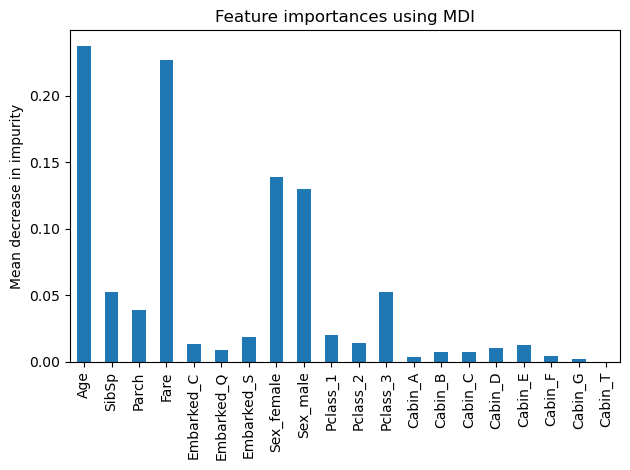

In [96]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

#### Among the top 5 features for Random Forest are Age, Fare, Female Sex, Passengers in Class 3, and  Male Sex.

#### 2. XGBoost feature importance

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:3: UserWarning: FixedFormatter should only be used together with FixedLocator
  This is separate from the ipykernel package so we can avoid doing imports until


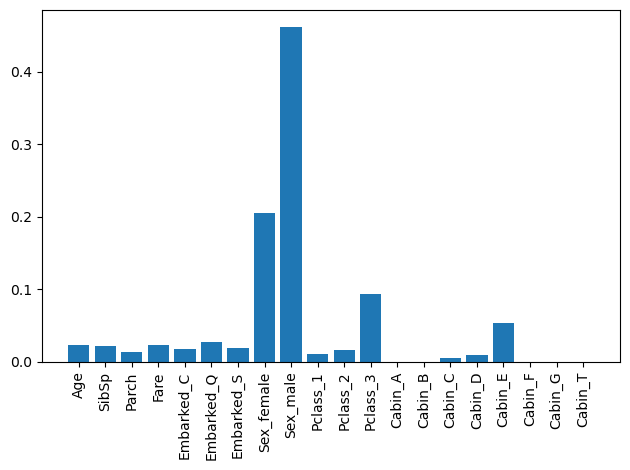

In [97]:

fig, ax = plt.subplots()
ax.bar(feature_names, XGB.feature_importances_)
ax.set_xticklabels(feature_names, rotation=90)
fig.tight_layout()

#### Among the top 5 features are Male Sex, Female Sex, Passengers in Class 3, Passengers in Cabin E, and Passengers from Embarked Q.

## Conclusion:
#### During training:
Based on the result of cross-validation, Random Forest has an accuracy of 0.835056 while XGBoost has an accuracy of 0.821581.

#### During testing:
Random Forest has higher accuracy score on the Test dataset than XGBoost.

Random Forest accuracy score: 0.77751

XGBoost accuracy score: 0.77033

The two models have similar accuracy performance